# MLP Armenian Pubs

This dataset contains information about age, gender, occupation, monthly income of respondents, their favorite pubs, frequency of visits, maximum amount that respondent ready to spend in the pub, an important features of the pub, the respondent's lifestyle and the regional stratum the respondent comes from, as well as occasions that the respondent goes to pubs most of the time.
<table>
    <tr>
        <td>Timestamp</td> <td>Date and time of respondent's submission</td> <td>string</td>
    </tr>
    <tr>
        <td>Age</td> <td>Respondent's age</td> <td>numeric</td>
    </tr>
    <tr>
        <td>Gender</td> <td>Respondent's gender</td> <td>string</td>
    </tr>
    <tr>
        <td>Income</td> <td>Respondent's approximate Monthly Income (in Armenian Dram)</td> <td>numeric</td>
    </tr>
    <tr>
        <td>Occupation</td> <td>Respondent's Occupation</td> <td>string</td>
    </tr>
    <tr>
        <td>Fav_Pub</td> <td>Respondent's Favorite Pub</td> <td>string</td>
    </tr>
    <tr>
        <td>WTS</td> <td>Respondent's maximum willingness to spend at the pub</td> <td>numeric</td>
    </tr>
    <tr>
        <td>Freq</td> <td>How often the respondnet visit pubs</td> <td>string</td>
    </tr>
    <tr>
        <td>Prim_Imp</td> <td>Feature of primary importantance for the respondent?</td> <td>string</td>
    </tr>
    <tr>
        <td>Sec_Imp</td> <td>Feature of secondary importantance for the respondent</td> <td>string</td>
    </tr>
    <tr>
        <td>Stratum</td> <td>The regional stratum the respondent comes from</td> <td>string</td>
    </tr>
    <tr>
        <td>Lifestyle</td> <td>Respondent's lifestyle</td> <td>string</td>
    </tr>
    <tr>
        <td>Occasions</td> <td>Occasions that the respondent goes to pubs most of the time</td> <td>string</td>
    </tr>
</table>

We will to predict a gender of respondents.

In [21]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

filename = './armenian_pubs.csv'
dataset = pd.read_csv(filename, sep = ',', engine = 'python')
dataset.columns = [u'time', u'age', u'gender', u'income', u'occupation', u'fav_pub',
                   u'wts', u'freq', u'1imp', u'2imp', u'stratum', u'life', u'occasions']


Preproccessing data.

Drop unused columns.

In [22]:
dataset = dataset.drop(['time'],axis = 1)
dataset = dataset.drop(['life'], axis = 1)
dataset = dataset.drop(['fav_pub'], axis = 1)
dataset = dataset.drop(['2imp'], axis = 1)
dataset = dataset.drop(['occasions'],axis = 1)

Fill NaN values with mean by column.

In [23]:
mean_income = dataset['income'].mean(axis = 0) 
dataset['income'] = map(lambda x: mean_income if numpy.isnan(dataset['income'][x]) else dataset['income'][x],range(len(dataset['income'])))
mean_wts = dataset['wts'].mean(axis = 0) 
dataset['wts'] = map(lambda x: mean_income if numpy.isnan(dataset['wts'][x]) else dataset['wts'][x],range(len(dataset['wts'])))


Now we need to transform non-numeric columns by replacing unique string with number.

In [24]:

dataset['freq'] = map(lambda x: 3 if x=='Several times a week' else x,dataset['freq'])
dataset['freq'] = map(lambda x: 2 if x=='Several times in a month' else x,dataset['freq'])
dataset['freq'] = map(lambda x: 1 if x=='rarely (once two week/or a month)' else x,dataset['freq'])
dataset['stratum'] = map(lambda x: 1 if x=='Capital' else x,dataset['stratum'])
dataset['stratum'] = map(lambda x: 2 if x=='Urban' else x,dataset['stratum'])
dataset['stratum'] = map(lambda x: 3 if x=='Rural' else x,dataset['stratum'])
dataset['1imp'] = map(lambda x: 1 if x=='Environment' else x,dataset['1imp'])
dataset['1imp'] = map(lambda x: 2 if x=='Music' else x,dataset['1imp'])
dataset['1imp'] = map(lambda x: 3 if x=='Pricing' else x,dataset['1imp'])
dataset['1imp'] = map(lambda x: 4 if x=='Menu' else x,dataset['1imp'])
i=-1
for x in dataset['occupation'][:]:
    i += 1
    if x == 'Student':
        dataset['occupation'][i]=1
    elif x == 'Student + working':
        dataset['occupation'][i]=2
    elif x == 'Working' or x == 'Working ':
        dataset['occupation'][i]=3
    elif x == 'Entrepreneur / Software Engineer':
        dataset['occupation'][i]=4
    else:
        dataset['occupation'][i]=5


dataset['gender'] = map(lambda x: 1 if x=='Male' else 0,dataset['gender'])



Drop the outlier points:

In [25]:
dataset['income'] = (dataset['income']-dataset['income'].mean(axis = 0))/dataset['income'].std(axis = 0)
dataset['wts'] = (dataset['wts']-dataset['wts'].mean(axis = 0))/dataset['wts'].std(axis = 0)
dataset=dataset.drop(dataset[dataset['income']>3*dataset['income'].std(axis = 0)].index)
dataset=dataset.drop(dataset[dataset['wts']>3*dataset['wts'].std(axis = 0)].index)

# The MLP

We want to predict a gender of respondents

In [26]:
x = dataset.drop('gender', axis = 1)
for xi in x:
    x[xi] = x[xi]/(abs(max(x[xi]))) #normalizing
y = dataset['gender']

The set of data have a small length. We will add to the set a random points from dataset.

In [27]:
bootstrap_index = lambda n: numpy.floor(numpy.random.rand()*n).astype(int)
N = 500
for i in xrange(N-len(y)):
    i = bootstrap_index(171)
    x=x.append(x[i:i+1])
    y=y.append(y[i:i+1])
len(x)

500

We need to split our set of data to 'train' and 'test' subsets (by 75% and 25% from common data respectively). We will fit classifier on 'train' subset and check it on 'test' subset.

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 30)
N_test, _ = x_test.shape

Create the MLP Classifier and fit it on 'train' subset. We use one hidden layer with 100 neurons and logistic activation function

In [29]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes = (100,), solver = 'lbfgs', 
                          activation = 'logistic', random_state = 42)
mlp_model.fit(x_train, y_train)



MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

Calculate an errors between predict and real values for both 'train' and 'test' subsets.

In [30]:
y_train_pred = mlp_model.predict(x_train)
y_test_pred = mlp_model.predict(x_test)
print(numpy.mean(y_train != y_train_pred), numpy.mean(y_test != y_test_pred))


(0.16800000000000001, 0.20799999999999999)


Fit a optimal parameters for classifier by minimizing errors.

In [31]:
alpha_arr = numpy.logspace(-4, 1, 21) #  regularization parameter
cn_arr = xrange(10,100,10) #  count of neurons in hidden layers
test_err = []
train_err = []
for alpha in alpha_arr:
    train_err_t = []
    test_err_t = []
    for cn in cn_arr:
        mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (cn+10,), 
                              solver = 'lbfgs', activation = 'logistic', random_state = 42)
        mlp_model.fit(x_train, y_train)

        y_train_pred = mlp_model.predict(x_train)
        y_test_pred = mlp_model.predict(x_test)
        train_err_t.append(numpy.mean(y_train != y_train_pred))
        test_err_t.append(numpy.mean(y_test != y_test_pred))    
    train_err.append(train_err_t)
    test_err.append(test_err_t)

Finding parameters values with minimal error

In [32]:
min_test_err = 100500
min_test_row = []
for test_row in test_err:
    if min_test_err > min(min_test_err, min(test_row)):
        min_test_err = min(min_test_err, min(test_row))
        min_test_row = test_row
alpha_min = test_err.index(min_test_row)
cn_min = test_err[alpha_min].index(min_test_err)
cn_opt = cn_arr[cn_min]
alpha_opt = alpha_arr[alpha_min]
print 'A minimal error',test_err[alpha_min][cn_min]
print 'with regularization parameter is ', alpha_opt, ' and count of neurons is ',cn_opt

A minimal error 0.128
with regularization parameter is  0.0001  and count of neurons is  20


Plot a relations between alpha and error, and between error and count of neurons: 

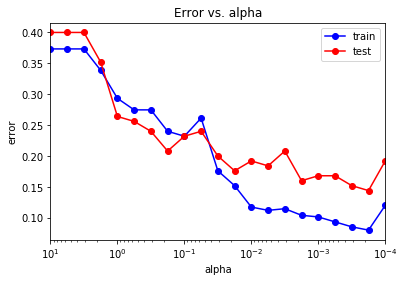

In [33]:
train_err_v = (zip(*train_err))[alpha_min]
test_err_v = (zip(*test_err))[alpha_min]
plt.semilogx(alpha_arr, train_err_v, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err_v, 'r-o', label = 'test')
plt.xlim([numpy.max(alpha_arr), numpy.min(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
plt.show()

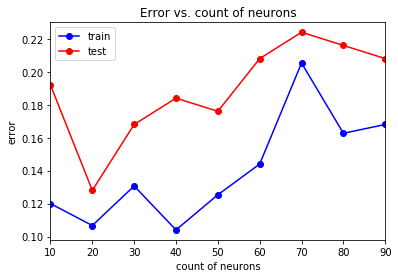

In [34]:
plt.plot(cn_arr, train_err[alpha_min], 'b-o', label = 'train')
plt.plot(cn_arr, test_err[alpha_min], 'r-o', label = 'test')
plt.xlim([numpy.min(cn_arr), numpy.max(cn_arr)])
plt.title('Error vs. count of neurons')
plt.xlabel('count of neurons')
plt.ylabel('error')
plt.legend()
plt.show()

Repeat fitting a classifier with optimal parameters

In [35]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (cn_opt,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(x_train, y_train)

y_train_pred = mlp_model.predict(x_train)
y_test_pred = mlp_model.predict(x_test)
print(numpy.mean(y_train != y_train_pred))
print(numpy.mean(y_test != y_test_pred))



0.12
0.192


Confusion matrix:

In [36]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))



[[65 14]
 [10 36]]


Other metrics of quality:

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.82      0.87      0.84        75
          1       0.78      0.72      0.75        50

avg / total       0.81      0.81      0.81       125



The obtained results of MLP a little better than kNN method due to bootstrapping. The number of neurons in hidden layer is better been taken approximately twice as much as the number of features of data. 